In [7]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"


import pandas as pd
import re
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load the dataset
file_path = "random_1000_clusters.csv"  # Change this if needed
df = pd.read_csv(file_path)

# Preprocessing function for Arabic text
def clean_arabic_text(text):
    text = text.lower()
    text = re.sub(r'[\u064B-\u0652]', '', text)  # Remove diacritics
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)  # Keep only Arabic letters
    text = text.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")
    text = text.replace("ة", "ه").replace("ي", "ى")
    return text.strip()

# Apply cleaning to the title column
df["clean_title"] = df["title"].apply(clean_arabic_text)

# Remove duplicate titles
df = df.drop_duplicates(subset=["clean_title"])

# Parse published_at to datetime
df["published_at"] = pd.to_datetime(df["published_at"], errors='coerce')

# Drop rows where date parsing failed
df = df.dropna(subset=["published_at"])

# Load Arabic BERT model
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=32)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Compute embeddings and add them to the dataframe
embeddings = np.array([get_bert_embedding(text) for text in df["clean_title"]])
df["embedding"] = list(embeddings)

# Sort by date
df = df.sort_values(by="published_at")

# Group by 3-day intervals
df['3day_group'] = (df['published_at'] - df['published_at'].min()).dt.days // 3

# Loop over each 3-day group
for group_id, group_df in df.groupby('3day_group'):
    if len(group_df) < 5:
        continue  # Skip small groups to avoid errors
    
    print(f"\nProcessing 3-day group {group_id} ({group_df['published_at'].min().date()} to {group_df['published_at'].max().date()})")
    
    group_embeddings = np.vstack(group_df["embedding"].values)
    
    # Choose the number of clusters dynamically if you want, or fix it
    num_clusters = min(10, len(group_df))  # Max 10 clusters or number of samples
    
    # K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    group_df["cluster"] = kmeans.fit_predict(group_embeddings)
    
    # TSNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(group_embeddings)
    
    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(num_clusters):
        cluster_points = reduced_embeddings[group_df["cluster"] == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}")
    plt.legend()
    plt.title(f"K-Means Clustering (Group {group_id})")
    plt.show()
    
    # Show sample titles
    for i in range(num_clusters):
        print(f"\nCluster {i} Sample Titles:")
        sample_titles = group_df[group_df["cluster"] == i]["title"]
        if len(sample_titles) >= 5:
            print(sample_titles.sample(5, random_state=42).tolist())
        else:
            print(sample_titles.tolist())
    print("===")


RuntimeError: Failed to import transformers.models.auto.tokenization_auto because of the following error (look up to see its traceback):
cannot import name 'get_cached_models' from 'transformers.utils' (C:\Users\HP\anaconda3\Lib\site-packages\transformers\utils\__init__.py)

In [67]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Compute silhouette score
silhouette_avg = silhouette_score(embeddings, df["cluster"])

# Compute Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(embeddings, df["cluster"])

# Compute Inertia (WCSS)
inertia = kmeans.inertia_

print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Inertia (WCSS): {inertia:.4f}")


Silhouette Score: 0.0327
Calinski-Harabasz Index: 1809.0764
Inertia (WCSS): 2664552.7500


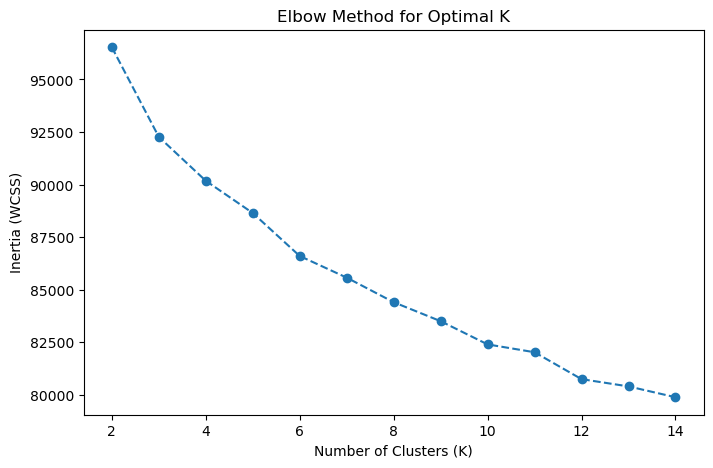

In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
K_range = range(35, 40)  # Testing K values from 2 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.show()


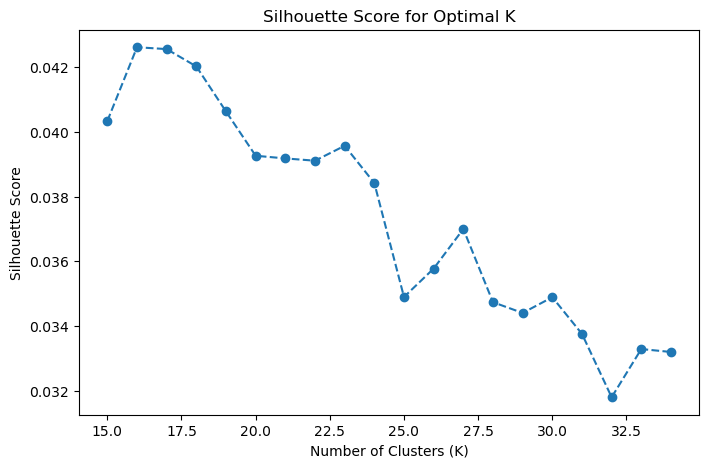

0.042610988


In [71]:
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(15, 35)  # Testing K values from 2 to 14
max_k=0
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    sil_scores.append(silhouette_score(embeddings, labels))
    if silhouette_score(embeddings, labels) >= max(sil_scores):
        max_k=k

plt.figure(figsize=(8, 5))
plt.plot(K_range, sil_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()
print(max(sil_scores),max_k)
# kmeans = KMeans(n_clusters=35, random_state=42, n_init=10)
# labels = kmeans.fit_predict(embeddings)
# print(silhouette_score(embeddings, labels))


In [1]:
import transformers
import torch
import tensorflow as tf

print("Transformers version:", transformers.__version__)
print("Torch version:", torch.__version__)
print("TensorFlow version:", tf.__version__)


ImportError: cannot import name 'float8_e4m3b11fnuz' from 'tensorflow.python.framework.dtypes' (C:\Users\HP\anaconda3\Lib\site-packages\tensorflow\python\framework\dtypes.py)